# Trabalho Final

Importando as bibliotecas que serão usadas

In [1]:
# Util
import operator
import math
import random
import numpy as np
from numpy import linspace, sin, pi, int16
import matplotlib.pyplot as plt
%matplotlib inline

# Genetic Programming
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import librosa
from IPython.display import Audio

import warnings; warnings.simplefilter('ignore')

Carregando o som desejado

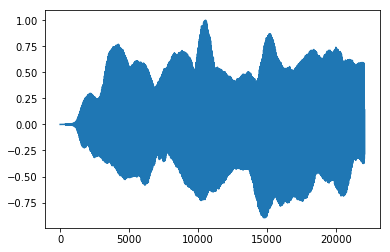

In [2]:
f0 = 440.0
#target, sr = librosa.load('SOUNDS/au_sample.wav')
target, sr = librosa.load('SOUNDS/flute.wav')
#target, sr = librosa.load('SOUNDS/harp.wav')
#target, sr = librosa.load('SOUNDS/string.wav')
target = librosa.util.normalize(target[:sr]) # normalizando etruncando para 1 segundo
duration = 1.0
plt.plot(target)
Audio(target,rate=sr)

In [3]:
# FUNCOES OPERADORES
def note(freq, amp=1.0):
    t = linspace(0,1.0,1.0*22050)
    data = sin(2.0*pi*freq*t)*amp
    return data

def fm(c_amp,c_freq, note_mod):
    t = linspace(0,1.0,1.0*22050)
    data = c_amp * sin(2.0*pi *(c_freq*t + note_mod))
    return data


In [4]:
def evaluate(individual):
    func = toolbox.compile(expr=individual)
    candidate = librosa.util.normalize(func(f0))
    
    candidate_mag = librosa.util.normalize(np.abs(librosa.stft(candidate)), axis=1)
    candidate_pha = librosa.util.normalize(np.angle(librosa.stft(candidate)), axis=1)
    
    target_mag = librosa.util.normalize(np.abs(librosa.stft(target)), axis=1)
    target_pha = librosa.util.normalize(np.angle(librosa.stft(target)), axis=1)
    
    mag_error = np.mean((candidate_mag - target_mag)**2)
    pha_error = np.mean((candidate_pha - target_pha)**2)
    
    return mag_error,pha_error,

In [5]:
# PROGRAMAÇÂO GENETICA
pset = gp.PrimitiveSetTyped("MAIN", [float], np.ndarray, "F")

# OPERATORS
pset.addPrimitive(note, [float, float], np.ndarray)
pset.addPrimitive(operator.add,[np.ndarray,np.ndarray],np.ndarray)
pset.addPrimitive(operator.mul,[np.ndarray,np.ndarray],np.ndarray)
pset.addPrimitive(fm, [float,float,np.ndarray], np.ndarray)
pset.addPrimitive(operator.add,[float,float],float)
# pset.addPrimitive(gen_cos, [float,float], list)

# TERMINALS
# if not scoop.IS_ORIGIN:
#    pset.addEphemeralConstant("rand100", lambda: random.random() * 100, float)
pset.addEphemeralConstant("rand100", lambda: random.random() * 100, float)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1), float)
pset.addTerminal(note(0), np.ndarray, 'zero')
pset.addTerminal(note(f0), np.ndarray, 'fundamental')
pset.addTerminal(note(2*f0), np.ndarray, 'harm1')
pset.addTerminal(note(3*f0), np.ndarray, 'harm2')
pset.addTerminal(note(4*f0), np.ndarray, 'harm3')
pset.addTerminal(f0, float)
pset.addTerminal(2*f0, float)
pset.addTerminal(3*f0, float)
pset.addTerminal(4*f0, float)

# CONFIG
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
# toolbox.register("map", futures.map)
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", evaluate)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))

In [6]:
def main():
    random.seed(15)
    pop = toolbox.population(n=7000)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    algorithms.eaSimple(pop, toolbox, 0.75, 0.2, 30, stats, halloffame=hof)

    return pop, stats, hof

In [7]:
pop, stats, hof = main()

gen	nevals	avg     	std    	min     	max     
0  	7000  	0.424156	0.23936	0.132737	0.768417
1  	5585  	0.395531	0.237058	0.11377 	0.833289
2  	5595  	0.36942 	0.225466	0.11377 	0.765993
3  	5593  	0.35905 	0.22375 	0.114789	0.795009
4  	5597  	0.380277	0.242453	0.115366	0.833463
5  	5584  	0.40436 	0.260779	0.114521	0.795098
6  	5598  	0.413327	0.269552	0.1039  	0.766065
7  	5616  	0.412743	0.272101	0.102683	1.26718 
8  	5497  	0.412167	0.273017	0.105002	0.890804
9  	5611  	0.411642	0.273268	0.103206	0.895161
10 	5594  	0.410909	0.273916	0.102764	0.76546 
11 	5627  	0.409694	0.275434	0.0971551	0.887277
12 	5605  	0.407297	0.276771	0.101772 	0.924458
13 	5606  	0.404995	0.27932 	0.102552 	0.924458
14 	5583  	0.402755	0.281942	0.0975769	0.924458
15 	5599  	0.400322	0.283263	0.097058 	1.26718 
16 	5578  	0.399166	0.285281	0.0963652	0.924458
17 	5541  	0.397688	0.286349	0.0963652	0.85242 
18 	5531  	0.39739 	0.286725	0.0926749	0.899944
19 	5648  	0.397372	0.286952	0.0930925	0.884464
20 	56

In [8]:
str(hof[0])

'add(mul(note(0.7229059879492961, 1760.0), note(F0, 1320.0)), mul(note(0.3949766709405278, F0), fm(66.29235956912981, add(38.109896248859144, add(440.0, add(1760.0, 880.0))), fm(440.0, 0.3949766709405278, mul(fundamental, fundamental)))))'

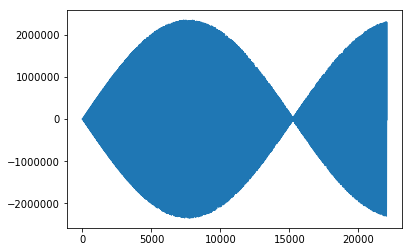

In [9]:
func = toolbox.compile(hof[0])
candidate = func(f0)
plt.plot(candidate)
Audio(candidate,rate=sr)